# galvanostatic_cycling

## Imports

In [2]:
import sys
from pathlib import Path
import re
from datetime import datetime
import numpy as np
import pandas as pd
from scipy.constants import physical_constants
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
from matplotlib.cm import get_cmap
from bg_mpl_stylesheet.bg_mpl_stylesheet import bg_mpl_style
import quantities
import molmass

## User inputs

### Plot settings

In [3]:
D_PLOT = dict(dpi = 600,
              figsize = (12,4),
              fontsize_labels=20,
              fontsize_ticks=14,
              t_std_label="$t\;[\mathrm{h}]$",
              x_std_label="$x$",
              cap_std_label="$Q\;[\mathrm{mAh/g}]$",
              cycle_std_label="$\mathrm{cycle}$",
              ce_std_label="$CE$",
              )

### Working electrode potential labels

In [4]:
D_EWE_LABEL = dict(Li="$E_{\mathrm{we}}\;\mathrm{vs.\;Li/Li^{+}\;[V]}$",
                   Na="$E_{\mathrm{we}}\;\mathrm{vs.\;Na/Na^{+}\;[V]}$",
                   Mg="$E_{\mathrm{we}}\;\mathrm{vs.\;Mg/Mg^{2+}\;[V]}$",
                   NMC="$E_{\mathrm{we}}\;\mathrm{vs.\;NMC\;[V]}$",
                   LTO="$E_{\mathrm{we}}\;\mathrm{vs.\;Li_{4}Ti_{5}O_{12}\;"
                       "[V]}$",
                   Other="$E_{\mathrm{we}}\;[\mathrm{V}]$",
                   )

### Working ion valences

In [5]:
D_WORKING_ION = dict(Li=1, Na=1, Mg=2)

### RGB colors for user-defined colormaps

In [6]:
D_RGB = dict(red=(255, 0, 0),
             green=(0, 255, 0),
             blue=(0, 0, 255),
             indigo=(75, 0, 130),
             magenta=(255, 0, 255),
             violet=(138, 43, 226),
             purple=(128, 0, 128),
             maroon=(128, 0, 0),
             teal=(0, 128, 128),
             navy=(0, 0, 128),
             cyan=(0, 255, 255),
             )

### Matplotlib colormaps

In [7]:
CMAPS = sorted([e for e in plt.colormaps()], key=str.lower)

### Indices used for MTI data extraction

In [8]:
D_INDICES = dict(voltage_index = 2,
                 current_index = 3,
                 capacity_index = 5,
                 date_index = -2,
                 time_index = -1,
                 )

### Biologic data headers

In [9]:
D_HEADER_BIOLOGIC = dict(time="time/s",
                         voltage="Ewe/V",
                         current="<I>/mA",
                         x="x",
                         capacity="Capacity/mA.h",
                         )

### Potentiostats

In [10]:
D_POTENTIOSTATS = {"0": "Biologic", "1": "MTI"}

### Plot modes

In [11]:
D_PLOT_MODES = {"0": "Colorbar", "1": "Legend"}

### Colormaps

In [12]:
D_CMAPS = {"0": "User-defined (from black to user-defined color)",
           "1": "Matplotlib colormap",}

## Biologic-specific functions

In [13]:
def biologic_header_check(file):
    with file.open(mode="r") as f:
        lines = f.readlines()
    header_check = "EC-Lab" in lines[0]

    return header_check


def biologic_remove_header_get_mass(file, output_path):
    with file.open(mode="r") as f:
        lines = f.readlines()
    header_lines = int(lines[1].split()[-1])
    for line in lines:
        if "Characteristic mass" in line:
            mass = float(line.split()[-2])
    output_path = output_path / file.name
    with output_path.open(mode="w") as o:
        o.writelines(lines[header_lines-1::])

    return output_path, mass


def biologic_extract(file, d_keys):
    df = pd.read_csv(file, delimiter="\t")
    keys = list(d_keys.keys())
    d = {}
    for k in keys:
        try:
            d[k] = df[d_keys[k]].to_numpy()
        except KeyError:
            print(f"\t{72*'*'}\n\tKeyError\n\tThe key '{d_keys[k]}' was "
                 f"missing from\n\t\t{file.name}\n\tPlease re-export the "
                 f"Biologic data with the following keys (and data)\n\t"
                 f"present:")
            for key in keys:
                print(f"\t\t{d_keys[key]}")
            print(f"\t{72*'*'}\nSkipping this file.")

            return None

    time, capacity = d["time"], d["capacity"]
    time_cycle_start = np.array([])
    for i in range(len(capacity)):
        if 10**-10 < capacity[i] < capacity[i-1]:
            time_cycle_start = np.append(time_cycle_start, time[i])
    d["time_cycle_start"] = time_cycle_start

    return d


def biologic_zero_capacity_if_resting(d):
    current, capacity = d["current"], d["capacity"]
    capacity_new = np.array([])
    for i in range(len(current)):
        if current[i] == 0:
            capacity_new = np.append(capacity_new, 0)
        else:
            capacity_new = np.append(capacity_new, capacity[i])

    return capacity_new


def biologic_merge_capacities(d):
    capacity_charge = d["capacity_charge"]
    capacity_discharge = d["capacity_discharge"]
    capacity = np.array([])
    for i in range(len(capacity_charge)):
        if capacity_charge[i] > 10**-10:
            capacity = np.append(capacity, capacity_charge[i])
        else:
            capapacity = np.append(capacity, capacity_discharge[i])
    d["capacity"] = capacity

    return d

## MTI-specific functions

In [14]:
def mti_extract(file, d_indices):
    with file.open(mode="r") as f:
        lines = f.readlines()
    header = lines[0:3]
    lines = lines[3::]
    modes = ["Rest", "CC_Chg", "CC_DChg"]
    start = None
    for i, line in enumerate(lines):
        line = line.split()
        for e in modes:
            if e in line:
                start = i + 1
                break
        if not isinstance(start, type(None)):
            break
    cols = len(lines[start].split())
    cols_cycles = len(lines[start-2].split())
    time_cycle_start = []
    for i in range(len(lines)):
        line_split = lines[i].split()
        if len(line_split) == cols_cycles:
            line_split_data = lines[i+2].split()
            date_split = line_split_data[d_indices["date_index"]].split("-")
            time_split = line_split_data[d_indices["time_index"]].split(":")
            time_cycle_start.append(datetime(int(date_split[0]),
                                             int(date_split[1]),
                                             int(date_split[2]),
                                             int(time_split[0]),
                                             int(time_split[1]),
                                             int(time_split[2])
                                             ).timestamp()
                                    )
    time_cycle_start = np.array(time_cycle_start)
    time_cycle_start = time_cycle_start - time_cycle_start[0]
    voltage, current, capacity, date, time, date_time = [], [], [], [], [], []
    for i in range(start, len(lines)):
        line = lines[i].split()
        if len(line) == cols:
            voltage.append(float(line[d_indices["voltage_index"]]))
            current.append(float(line[d_indices["current_index"]]))
            capacity.append(float(line[d_indices["capacity_index"]]))
            date.append(line[d_indices["date_index"]])
            time.append(line[d_indices["time_index"]])
    for i in range(len(date)):
        date_split = date[i].split("-")
        time_split = time[i].split(":")
        date_time.append(datetime(int(date_split[0]),
                                  int(date_split[1]),
                                  int(date_split[2]),
                                  int(time_split[0]),
                                  int(time_split[1]),
                                  int(time_split[2])
                                  ).timestamp()
                        )
    voltage, current = np.array(voltage), np.array(current) * 10**-3
    capacity = np.array(capacity)
    date_time = np.array(date_time)
    time = date_time - date_time[0]
    d = dict(time=time,
             voltage=voltage,
             current=current,
             capacity=capacity,
             time_cycle_start=time_cycle_start,
             )

    return d

## General functions

### Miscellaneous

In [15]:
def comma_to_dot(file, output_path):
    with file.open(mode="r") as f:
        s = f.read().replace(",", ".")
    output_path = output_path / file.name
    with output_path.open(mode="w") as o:
        o.write(s)

    return output_path


def make_x_label(formula, working_ion):
    elements = re.sub( r"([A-Z])", r" \1", formula).split()
    xlabel = "$x\;\mathrm{in\;"
    for i,e in enumerate(elements):
        s = re.split('(\d.*)', e)
        if i == 0:
            if s[0] != working_ion:
                xlabel += working_ion + "}_{x}\mathrm{" + s[0]
            else:
                xlabel += str(s[0]) + "}_{x}\mathrm{"
        else:
            xlabel += str(s[0])
            if len(s) != 1:
                xlabel += "_{" + str(s[1]) + "}"
    xlabel += "}$"

    return xlabel


def half_cycles_start(d):
    time, current = d["time"], d["current"]
    half_cycles_start = np.array([i for i in range(1, len(current))
                                  if current[i] != 0
                                  and current[i] * current[i-1] <= 0
                                  ])

    return half_cycles_start


def half_cycles_end(d):
    time, current = d["time"], d["current"]
    half_cycles_end = np.array([i for i in range(1, len(current))
                                if current[i-1] != 0
                                and current[-1] * current[i] <= 0
                                ])

    return half_cycles_end


def merge_half_cycles_to_cycles(d):
    half_cycles = list(d.keys())
    keys = list(d[half_cycles[0]].keys())
    d_cycles = {}
    counter = 0
    for i in range(len(half_cycles)):
        if i % 2 == 0:
            d_cycles[counter] = {}
            for k in keys:
                d_cycles[counter][k] = d[half_cycles[i]][k]
        else:
            for k in keys:
                d_cycles[counter][k] = np.append(d_cycles[counter][k],
                                                 d[half_cycles[i]][k],
                                                 )
            counter += 1

    return d_cycles

### Calculators

In [16]:
def molar_mass_calc(formula):
    elements = re.sub( r"([A-Z])", r" \1", formula).split()
    molar_mass = 0
    for e in elements:
        s = re.split('(\d.*)', e)
        if len(s) == 1:
            s.append(1)
        if s[-1] == "":
            s = s[0:-1]
        f = molmass.Formula(s[0])
        m = float(s[1]) * f.mass
        molar_mass += m

    return molar_mass


def x_calc(d, mass, molar_mass, x_start, working_ion_valence):
    time, current = d["time"], d["current"]
    n = mass / molar_mass
    f = physical_constants["Faraday constant"][0]
    x = [x_start]
    for i in range(1, len(time)):
        delta_q =  current[i] * (time[i] - time[i-1]) / working_ion_valence
        delta_x = - delta_q / (n * f)
        x.append(x[i-1] + delta_x)
    x = np.array(x)

    return x

### Extractors

In [17]:
def extract_cycles(d):
    time_cycle_start = d["time_cycle_start"]
    time, voltage, current, x = d["time"], d["voltage"], d["current"], d["x"]
    capacity = d["capacity"]
    cycle_start_indices = []
    for i in range(len(time_cycle_start)):
        for j in range(len(time)):
            if time_cycle_start[i] == time[j]:
                if len(cycle_start_indices) > 0:
                    if time[j] - time[cycle_start_indices[-1]] > 0:
                        cycle_start_indices.append(j)
                else:
                    cycle_start_indices.append(j)
    d_cycles = {}
    for i in range(len(cycle_start_indices)-1):
        d_cycles[i] = dict(time = time[cycle_start_indices[i]:
                                       cycle_start_indices[i+1]
                                       ],
                           voltage = voltage[cycle_start_indices[i]:
                                             cycle_start_indices[i+1]
                                             ],
                           current = current[cycle_start_indices[i]:
                                             cycle_start_indices[i+1]
                                             ],
                           capacity = capacity[cycle_start_indices[i]:
                                               cycle_start_indices[i+1]
                                               ],
                           x = x[cycle_start_indices[i]:
                                 cycle_start_indices[i+1]
                                 ],
                           )
    d_cycles[i+1] = dict(time = time[cycle_start_indices[i+1]::],
                         voltage = voltage[cycle_start_indices[i+1]:],
                         current = current[cycle_start_indices[i+1]:],
                         x = x[cycle_start_indices[i+1]:],
                         capacity = capacity[cycle_start_indices[i+1]:],
                         )

    return d_cycles


def extract_half_cycles(d):
    time_cycle_start = d["time_cycle_start"]
    time, voltage, current, x = d["time"], d["voltage"], d["current"], d["x"]
    capacity = d["capacity"]
    current_end_indices = []
    for i in range(1, len(current)):
        if current[i-1] != 0 and current[i] == 0:
            current_end_indices.append(i)
    d_half_cycles = {"0": dict(time=time[0:current_end_indices[0]],
                               voltage=voltage[0:current_end_indices[0]],
                               current=current[0:current_end_indices[0]],
                               capacity=capacity[0:current_end_indices[0]],
                               x=x[0:current_end_indices[0]],
                               )
                    }
    for i in range(len(current_end_indices)-1):
        d_half_cycles[i+1] = dict(time=time[current_end_indices[i]:
                                            current_end_indices[i+1]
                                            ],
                                  voltage=voltage[current_end_indices[i]:
                                                  current_end_indices[i+1]
                                                  ],
                                  current=current[current_end_indices[i]:
                                                  current_end_indices[i+1]
                                                  ],
                                  capacity=capacity[current_end_indices[i]:
                                                    current_end_indices[i+1]
                                                    ],
                                  x=x[current_end_indices[i]:
                                      current_end_indices[i+1]
                                      ],
                                  )
    d_half_cycles[i+2] = dict(time=time[current_end_indices[i+1]:],
                              voltage=voltage[current_end_indices[i+1]:],
                              current=current[current_end_indices[i+1]:],
                              capacity=capacity[current_end_indices[i+1]:],
                              x=x[current_end_indices[i+1]:],
                              )

    return d_half_cycles


def capacities_extract(d):
    half_cycles = list(d.keys())
    cap_charge, cap_discharge = [], []
    for e in half_cycles:
        current, capacity = d[e]["current"], d[e]["capacity"]
        if current[-1] > 10**-5:
            cap_charge.append(capacity[-1])
        else:
            cap_discharge.append(capacity[-1])
    cap_charge, cap_discharge = np.array(cap_charge), np.array(cap_discharge)
    if len(cap_charge) == len(cap_discharge):
        coulomb_eff = cap_discharge / cap_charge
    elif len(cap_charge) > len(cap_discharge):
        coulomb_eff = cap_discharge / cap_charge[0:len(cap_discharge)]
    elif len(cap_charge) < len(cap_discharge):
        coulomb_eff = cap_discharge[0:len(cap_charge)] / cap_charge
    d_caps = dict(charge=cap_charge,
                  discharge=cap_discharge,
                  coulomb_eff=coulomb_eff,
                  )

    return d_caps


### Writers

In [18]:
def write(d, output_path):
    keys = list(d.keys())
    header = f"t [s]\tV [V]\tI [A]\tQ [mAh/g]\tx"
    array = d[keys[0]]
    for i in range(1, len(keys)):
        if not keys[i] in ["half_cycles_start",
                           "half_cycles_end",
                           "time_cycle_start",
                           ]:
            array = np.column_stack((array, d[keys[i]]))
    np.savetxt(output_path,
               array,
               header=header,
               fmt="%.6e",
               delimiter="\t",
               encoding="utf8",
               )

    return None


def cycles_write(d, output_path):
    cycles = list(d.keys())
    for cycle in cycles:
        keys = list(d[cycle].keys())
        header = f"t [s]\tV [V]\tI [A]\tQ [mAh/g]\tx"
        array = d[cycle][keys[0]]
        for i in range(1, len(keys)):
            array = np.column_stack((array, d[cycle][keys[i]]))
        cycle = cycle + 1
        zfill = str(cycle).zfill(2)
        fname = f"{output_path.stem}_cycle-{zfill}{output_path.suffix}"
        output_path_cycle = output_path.parent / fname
        np.savetxt(output_path_cycle,
                   array,
                   header=header,
                   fmt="%.6e",
                   delimiter="\t",
                   encoding="utf8",
                   )

    return None

### Plotters

In [19]:
def plot_time_voltage(filename, d_data, d_plot, plot_paths):
    time, voltage = d_data["time"]*60**-2, d_data["voltage"]
    plt.style.use(bg_mpl_style)
    fig, ax = plt.subplots(dpi=d_plot["dpi"], figsize=d_plot["figsize"])
    colors = d_plot["colors"](np.linspace(0, 1, 10))
    ax.plot(time, voltage, c=colors[-2])
    ax.set_xlabel(d_plot["t_std_label"], fontsize=d_plot["fontsize_labels"])
    ax.set_ylabel(d_plot["ewe_label"], fontsize=d_plot["fontsize_labels"])
    ax.tick_params(axis="both", labelsize=d_plot["fontsize_ticks"])
    ax.minorticks_on()
    ax.set_xlim(np.amin(time), np.amax(time))
    for p in plot_paths:
        # print(f"\t\t\t{p.parent.name}")
        output_path = p / f"{filename}_t-ewe.{p.parent.name}"
        plt.savefig(output_path, bbox_inches="tight")
    # plt.close()
    plt.show()

    return None


def plot_x_voltage(filename, d_data, d_plot, plot_paths):
    x, voltage = d_data["x"], d_data["voltage"]
    plt.style.use(bg_mpl_style)
    colors = d_plot["colors"](np.linspace(0, 1, 3))
    fig, ax = plt.subplots(dpi=d_plot["dpi"], figsize=d_plot["figsize"])
    ax.plot(x, voltage, color=colors[1])
    ax.set_xlabel(d_plot["x_std_label"], fontsize=d_plot["fontsize_labels"])
    ax.set_ylabel(d_plot["ewe_label"], fontsize=d_plot["fontsize_labels"])
    ax.tick_params(axis="both", labelsize=d_plot["fontsize_ticks"])
    ax.minorticks_on()
    ax.set_xlim(np.amin(x), np.amax(x))
    for p in plot_paths:
        # print(f"\t\t\t{p.parent.name}")
        output_path = p / f"{filename}_x-ewe.{p.parent.name}"
        plt.savefig(output_path, bbox_inches="tight")
    # plt.close()
    plt.show()

    return None


def plot_x_voltage_cycles_cbar(filename, d, d_plot, plot_paths, save=True):
    half_cycles = list(d.keys())
    n_cycles = int(np.ceil(len(half_cycles) / 2))
    colors = d_plot["colors"](np.linspace(0, 1, n_cycles))
    plt.style.use(bg_mpl_style)
    fig, axs = plt.subplots(dpi=d_plot["dpi"],
                            figsize=d_plot["figsize"],
                            ncols=2,
                            gridspec_kw=dict(width_ratios=[1, 0.01]),
                            )
    xmin, xmax = [], []
    counter = 0
    for i in range(len(half_cycles)):
        x, voltage = d[half_cycles[i]]["x"], d[half_cycles[i]]["voltage"]
        xmin.append(np.amin(x))
        xmax.append(np.amax(x))
        if i % 2 == 0:
            counter += 1
            label = str(counter)
        else:
            label = None
        axs[0].plot(x, voltage, label=label, c=colors[counter-1])
    xmin, xmax = np.amin(np.array(xmin)), np.amax(np.array(xmax))
    xrange = xmax - xmin
    axs[0].set_xlabel(d_plot["x_label"],
                      fontsize=d_plot["fontsize_labels"],
                      )
    axs[0].set_ylabel(d_plot["ewe_label"],
                      fontsize=d_plot["fontsize_labels"],
                      )
    axs[0].tick_params(axis="both", labelsize=d_plot["fontsize_ticks"])
    axs[0].minorticks_on()
    axs[0].set_xlim(xmin - 0.01 * xrange, xmax + 0.01 * xrange)
    sm = plt.cm.ScalarMappable(cmap=d_plot["colors"].reversed(),
                               norm=plt.Normalize(vmin=0, vmax=1),
                               )
    cbar = plt.colorbar(sm,
                        cax=axs[1],
                        ticks=[0, 1],
                        )
    cbar.ax.set_yticklabels(["end", "start"])
    cbar.ax.tick_params(axis="y")
    plt.subplots_adjust(wspace=0.05)
    for p in plot_paths:
        # print(f"\t\t\t{p.parent.name}")
        output_path = p / f"{filename}_x-ewe.{p.parent.name}"
        plt.savefig(output_path, bbox_inches="tight")
    # plt.close()
    plt.show()

    return None


def plot_x_voltage_cycles_legend(filename, d, d_plot, plot_paths):
    half_cycles = list(d.keys())
    n_cycles = int(np.ceil(len(half_cycles) / 2))
    colors = d_plot["colors"](np.linspace(0, 1, n_cycles))
    plt.style.use(bg_mpl_style)
    fig, ax = plt.subplots(dpi=d_plot["dpi"],
                            figsize=d_plot["figsize"],
                            )
    xmin, xmax = [], []
    counter = 0
    for i in range(len(half_cycles)):
        x, voltage = d[half_cycles[i]]["x"], d[half_cycles[i]]["voltage"]
        xmin.append(np.amin(x))
        xmax.append(np.amax(x))
        if i % 2 == 0:
            counter += 1
            label = str(counter)
        else:
            label = None
        ax.plot(x, voltage, label=label, c=colors[counter-1])
    xmin, xmax = np.amin(np.array(xmin)), np.amax(np.array(xmax))
    xrange = xmax - xmin
    ax.set_xlabel(d_plot["x_label"], fontsize=d_plot["fontsize_labels"])
    ax.set_ylabel(d_plot["ewe_label"], fontsize=d_plot["fontsize_labels"])
    ax.tick_params(axis="both", labelsize=d_plot["fontsize_ticks"])
    ax.minorticks_on()
    ax.set_xlim(xmin - 0.01 * xrange, xmax + 0.01 * xrange)
    if np.ceil(len(half_cycles) / 2) <= 7:
        ncols = int(np.ceil(len(half_cycles) / 2))
        offset = 0.15
    else:
        ncols = 8
        if 1 < (len(half_cycles) / 2) / ncols <= 2:
            offset = 0.25
        elif 2 < (len(half_cycles) / 2) / ncols <= 3:
            offset = 0.375
        elif 3 < (len(half_cycles) / 2) / ncols <= 4:
            offset = 0.45
        elif 4 < (len(half_cycles) / 2) / ncols <= 5:
            offset = 0.55
        else:
            print(f"\t\t\tToo many cycles to get right offset for legend.\n"
                  f"\t\t\tSetting legend offset to 0.\n\t\t\tPlease "
                  f"consider using a colorbar instead of a legend.\n")
            offset = 0
    handles, labels = ax.get_legend_handles_labels()
    handles_sorted, labels_sorted = [], []
    for i in range(ncols):
        for j in range(len(labels)):
            if (int(labels[j]) + ncols - 1) % ncols == i:
                handles_sorted.append(handles[j])
                labels_sorted.append(labels[j])
    ax.legend(handles=handles_sorted,
              labels=labels_sorted,
              loc="upper center",
              bbox_to_anchor=(0.5, 1 + offset),
              ncols=ncols,
              framealpha=0,
              )
    for p in plot_paths:
        # print(f"\t\t\t{p.parent.name}")
        output_path = p / f"{filename}_x-ewe.{p.parent.name}"
        plt.savefig(output_path, bbox_inches="tight")
    # plt.close()
    plt.show()

    return None


def plot_capacity_voltage_cbar(filename, d, d_plot, plot_paths):
    half_cycles = list(d.keys())
    n_cycles = int(np.ceil(len(half_cycles) / 2))
    plt.style.use(bg_mpl_style)
    colors = d_plot["colors"](np.linspace(0, 1, n_cycles))
    fig, axs = plt.subplots(dpi=d_plot["dpi"],
                            figsize=d_plot["figsize"],
                            ncols=2,
                            gridspec_kw=dict(width_ratios=[1, 0.01]),
                            )
    xmin, xmax = [], []
    counter = 0
    for i in range(len(half_cycles)):
        capacity = d[half_cycles[i]]["capacity"]
        voltage = d[half_cycles[i]]["voltage"]
        xmin.append(np.amin(capacity))
        xmax.append(np.amax(capacity))
        if i % 2 == 0:
            counter += 1
            label = str(counter)
        else:
            label = None
        axs[0].plot(capacity, voltage, label=label, c=colors[counter-1])
    axs[0].set_xlabel(d_plot["cap_std_label"], fontsize=d_plot["fontsize_labels"])
    axs[0].set_ylabel(d_plot["ewe_label"], fontsize=d_plot["fontsize_labels"])
    axs[0].tick_params(axis="both", labelsize=d_plot["fontsize_ticks"])
    axs[0].minorticks_on()
    xmin, xmax = np.amin(np.array(xmin)), np.amax(np.array(xmax))
    xrange = xmax - xmin
    axs[0].set_xlim(xmin - (0.01 * xrange), xmax + (0.01 * xrange))
    sm = plt.cm.ScalarMappable(cmap=d_plot["colors"].reversed(),
                               norm=plt.Normalize(vmin=0, vmax=1),
                               )
    cbar = plt.colorbar(sm,
                        cax=axs[1],
                        ticks=[0, 1],
                        )
    cbar.ax.set_yticklabels(["end", "start"])
    cbar.ax.tick_params(axis="y")
    plt.subplots_adjust(wspace=0.05)
    for p in plot_paths:
        # print(f"\t\t\t{p.parent.name}")
        output_path = p / f"{filename}_cap-ewe.{p.parent.name}"
        plt.savefig(output_path, bbox_inches="tight")
    # plt.close()
    plt.show()

    return None


def plot_capacity_voltage_legend(filename, d, d_plot, plot_paths):
    half_cycles = list(d.keys())
    n_cycles = int(np.ceil(len(half_cycles) / 2))
    plt.style.use(bg_mpl_style)
    colors = d_plot["colors"]
    colors = colors(np.linspace(0, 1, n_cycles))
    fig, ax = plt.subplots(dpi=d_plot["dpi"], figsize=d_plot["figsize"])
    xmin, xmax = [], []
    counter = 0
    for i in range(len(half_cycles)):
        capacity = d[half_cycles[i]]["capacity"]
        voltage = d[half_cycles[i]]["voltage"]
        xmin.append(np.amin(capacity))
        xmax.append(np.amax(capacity))
        if i % 2 == 0:
            counter += 1
            label = str(counter)
        else:
            label = None
        ax.plot(capacity, voltage, label=label, c=colors[counter-1])
    ax.set_xlabel(d_plot["cap_std_label"], fontsize=d_plot["fontsize_labels"])
    ax.set_ylabel(d_plot["ewe_label"], fontsize=d_plot["fontsize_labels"])
    ax.tick_params(axis="both", labelsize=d_plot["fontsize_ticks"])
    ax.minorticks_on()
    xmin, xmax = np.amin(np.array(xmin)), np.amax(np.array(xmax))
    xrange = xmax - xmin
    ax.set_xlim(xmin - (0.01 * xrange), xmax + (0.01 * xrange))
    if np.ceil(len(half_cycles) / 2) <= 7:
        ncols = int(np.ceil(len(half_cycles) / 2))
        offset = 0.15
    else:
        ncols = 8
        if 1 < (len(half_cycles) / 2) / ncols <= 2:
            offset = 0.25
        elif 2 < (len(half_cycles) / 2) / ncols <= 3:
            offset = 0.375
        elif 3 < (len(half_cycles) / 2) / ncols <= 4:
            offset = 0.45
        elif 4 < (len(half_cycles) / 2) / ncols <= 5:
            offset = 0.55
        else:
            print(f"\t\t\tToo many cycles to get right offset for legend.\n"
                  f"\t\t\tSetting legend offset to 0.\n\t\t\tPlease "
                  f"consider using a colorbar instead of a legend.\n")
            offset = 0
    handles, labels = ax.get_legend_handles_labels()
    handles_sorted, labels_sorted = [], []
    for i in range(ncols):
        for j in range(len(labels)):
            if (int(labels[j]) + ncols - 1) % ncols == i:
                handles_sorted.append(handles[j])
                labels_sorted.append(labels[j])
    ax.legend(handles=handles_sorted,
              labels=labels_sorted,
              loc="upper center",
              bbox_to_anchor=(0.5, 1 + offset),
              ncols=ncols,
              framealpha=0,
              )
    for p in plot_paths:
        # print(f"\t\t\t{p.parent.name}")
        output_path = p / f"{filename}_cap-ewe.{p.parent.name}"
        plt.savefig(output_path, bbox_inches="tight")
    # plt.close()
    plt.show()

    return None


def plot_cycle_capacity(filename, d, d_plot, plot_paths):
    capacity_charge, capacity_discharge = d["charge"], d["discharge"]
    plt.style.use(bg_mpl_style)
    colors = d_plot["colors"](np.linspace(0, 1, 10))
    fig, ax = plt.subplots(dpi=d_plot["dpi"], figsize=d_plot["figsize"])
    ax.scatter(range(1, len(capacity_charge) + 1),
               capacity_charge,
               color=colors[0],
               label="charge",
               )
    ax.scatter(range(1, len(capacity_discharge) + 1),
               capacity_discharge,
               color=colors[-2],
               label="discharge",
               )
    xmin, xmax = 1, max(len(capacity_charge), len(capacity_discharge))
    xrange = xmax - xmin
    ax.set_xlim(xmin - 0.01 * xrange, xmax + 0.01 * xrange)
    ax.set_xlabel(d_plot["cycle_std_label"], fontsize=d_plot["fontsize_labels"])
    ax.set_ylabel(d_plot["cap_std_label"], fontsize=d_plot["fontsize_labels"])
    ax.tick_params(axis="both", labelsize=d_plot["fontsize_ticks"])
    ax.minorticks_on()
    ax.legend(loc="upper center",
              bbox_to_anchor=(0.5, 1.15),
              ncols=2,
              framealpha=0,
              )
    for p in plot_paths:
        # print(f"\t\t\t{p.parent.name}")
        output_path = p / f"{filename}_cycle-cap.{p.parent.name}"
        plt.savefig(output_path, bbox_inches="tight")
    # plt.close()
    plt.show()

    return None


def plot_cycle_ce(filename, d, d_plot, plot_paths):
    ce = d["coulomb_eff"]
    plt.style.use(bg_mpl_style)
    fig, ax = plt.subplots(dpi=d_plot["dpi"], figsize=d_plot["figsize"])
    colors = d_plot["colors"](np.linspace(0, 1, 10))
    ax.scatter(range(1, len(ce) + 1), ce, color=colors[-2])
    xmin, xmax = 1, max(len(ce), len(ce))
    xrange = xmax - xmin
    ymin, ymax = np.amin(ce), np.amax(ce)
    ce_sorted = sorted(ce, reverse=True)
    ce_max = [e for e in ce_sorted if e <= 1]
    if len(ce_max) > 0:
        ymax = ce_max[0]
    else:
        ymax = np.amax(ce)
    if ymax > 1:
        ymax = 1
    yrange = ymax - ymin
    ax.set_xlim(xmin - 0.01 * xrange, xmax + 0.01 * xrange)
    ax.set_ylim(ymin - 0.05 * yrange, ymax + 0.05 * yrange)
    ax.set_xlabel(d_plot["cycle_std_label"], fontsize=d_plot["fontsize_labels"])
    ax.set_ylabel(d_plot["ce_std_label"], fontsize=d_plot["fontsize_labels"])
    ax.tick_params(axis="both", labelsize=d_plot["fontsize_ticks"])
    ax.minorticks_on()
    for p in plot_paths:
        # print(f"\t\t\t{p.parent.name}")
        output_path = p / f"{filename}_cycle-ce.{p.parent.name}"
        plt.savefig(output_path, bbox_inches="tight")
    # plt.close()
    plt.show()

    return None

## Input directory

In [20]:
data_path = Path.cwd() / "data"
if not data_path.exists():
    data_path.mkdir()
    sys.exit(f"{80*'-'}\nA folder called 'data' has been created.\n"
             f"Please place your .txt files containing GC data there and "
             f"rerun the program.\n{80*'-'}"
             )

## Listing data files

In [21]:
data_files = list(data_path.glob("*.txt"))
if len(data_files) == 0:
    sys.exit(f"{80*'-'}\nNo .txt files were found in the 'data' folder.\n"
             f"Please place your .txt files containing GC data there and "
             f"rerun the program.\n{80*'-'}"
             )

## Output directories

In [22]:
txt_path = Path.cwd() / "txt"
data_ctd_path = Path.cwd() / "data_comma-to-dot"
data_nh_path = Path.cwd() / "data_no-header"
png_path, pdf_path = Path.cwd() / "png", Path.cwd() / "pdf"
svg_path = Path.cwd() / "svg"
output_paths = [txt_path,
                data_ctd_path,
                data_nh_path,
                png_path,
                pdf_path,
                svg_path,
                ]
for p in output_paths:
    if not p.exists():
        p.mkdir()
output_paths = [txt_path, png_path, pdf_path, svg_path,]

## Extracting, writing, and plotting

### Choose data file

In [23]:
print(f"Available datafiles...\n{80*'='}")
for i,f in enumerate(data_files):
    print(f"{i}\t{f.name}")
print(f"{80*'='}\nq\tquit")
file_not_found = True
while file_not_found:
    f_index = input(f"\nPlease provide the index of the data file that "
                    f"the user wish to process or 'q'\nif the user "
                    f"wish to quit the program: ")
    if f_index.lower() == "q":
        cont_program = False
        sys.exit(f"{80*'-'}\nThe program has been quit upon user "
                 f"request.")
    elif f_index in [str(e) for e in range(len(data_files))]:
        f = data_files[int(f_index)]
        file_not_found = False
    else:
        print(f"{80*'*'}\nIndex not found. Please try again."
              f"\n{80*'*'}")

Available datafiles...
0	00_BIOLOGIC_NO_CURRENT.txt
1	01_BIOLOGIC_NO_X.txt
2	02_BIOLOGIC_Na07Fe033Mn067O2-Na_6dot29.txt
3	03_BIOLOGIC_Na07Fe033Mn067O2-Na_6dot29_header.txt
4	10_MTI_LiNMC811-LTO_14dot875.txt
q	quit



Please provide the index of the data file that the user wish to process or 'q'
if the user wish to quit the program:  4


### Choose potentiostat

In [24]:
print(f"Working w. file: {f.name}.")
for p in output_paths:
    if not (p / f.stem).exists():
        (p / f.stem).mkdir()
txt_path_sample, png_path_sample = txt_path / f.stem, png_path / f.stem
pdf_path_sample, svg_path_sample = pdf_path / f.stem, svg_path / f.stem
potentiostat_keys = list(D_POTENTIOSTATS.keys())
potentiostat_not_found = True
while potentiostat_not_found:
    print(f"\nAvailable potentiostats:")
    for k,v in D_POTENTIOSTATS.items():
        print(f"{k}\t{v}")
    gc_type = input(f"\nPlease provide the index of the potentiostat "
                    f"used to collect the GC\ndata: ")
    if gc_type not in potentiostat_keys:
        print(f"{80*'*'}\nIndex not found. Please try again.\n"
              f"{80*'*'}")
    else:
        potentiostat_not_found = False

Working w. file: 10_MTI_LiNMC811-LTO_14dot875.txt.

Available potentiostats:
0	Biologic
1	MTI



Please provide the index of the potentiostat used to collect the GC
data:  1


### Extracting data

In [25]:
if gc_type == "0":
    print(f"Converting commas to dots...")
    f = comma_to_dot(f, data_ctd_path)
    header_check = biologic_header_check(f)
    if header_check:
        f, mass = biologic_remove_header_get_mass(f, data_nh_path)
        print(f"\nThe following characteristic mass was read from "
              f"the header of the\nfile: {mass} mg")
        mass = mass * 10**-3
    d_data = biologic_extract(f, D_HEADER_BIOLOGIC)
    if isinstance(d_data, type(None)):
        sys.exit(f"\n{80*'-'}\nPlease re-run the code for a new "
                 f"input file.\n{80*'-'}")
    d_data["capacity"] = biologic_zero_capacity_if_resting(d_data)
    print("Done extracting data.")
    if not header_check:
        mass_not_found = True
        while mass_not_found:
            try:
                mass = float(input(f"\nPlease provide the mass of "
                                   f"the active electrode material "
                                   f"(in mg): "
                                   )) * 10**-3
                mass_not_found = False
            except ValueError:
                print(f"{80*'*'}\nValueError. Please try again.\n"
                      f"{80*'*'}")
elif gc_type == "1":
    print(f"\nExtracting data...")
    d_data = mti_extract(f, D_INDICES)
    print("Done extracting data.")
    mass_not_found = True
    while mass_not_found:
        try:
            mass = float(input(f"\nPlease provide the mass of the "
                               f"active electrode material (in mg): "
                               )) * 10**-3
            mass_not_found = False
        except ValueError:
            print(f"{80*'*'}\nValueError. Please try again.\n"
                  f"{80*'*'}")


Extracting data...
Done extracting data.



Please provide the mass of the active electrode material (in mg):  14.875


### Chemical formula and molar mass

In [26]:
formula_not_found = True
while formula_not_found:
    try:
        formula = input(f"Please provide the empirical formula, "
                        f"e.g. LiFePO4, of the active\nelectrode "
                        f"material: ")
        molar_mass = molar_mass_calc(formula)
        formula_not_found = False
    except molmass.molmass.FormulaError:
        print(f"{80*'*'}\nFormulaError. Please try again.\n"
              f"{80*'*'}")
print(f"\nCalculated molar mass for {formula}: {molar_mass:.6f} "
      f"g/mol")

Please provide the empirical formula, e.g. LiFePO4, of the active
electrode material:  LiNi0.8Mn0.1Co0.1O2



Calculated molar mass for LiNi0.8Mn0.1Co0.1O2: 97.280654 g/mol


### Initial working ion content

In [27]:
x_start_not_found = True
while x_start_not_found:
    try:
        x_start = float(input(f"Please provide the initial value "
                              f"for x, i.e. initial working ion "
                              f"content\nof the electrode, e.g. 1 "
                              f"for LiFePO4: "))
        x_start_not_found = False
    except ValueError:
        print(f"{80*'*'}\nValueError. Please try again.\n"
              f"{80*'*'}")

Please provide the initial value for x, i.e. initial working ion content
of the electrode, e.g. 1 for LiFePO4:  1


### Working ion

In [28]:
wi_keys = list(D_WORKING_ION.keys())
working_ion_not_found = True
while working_ion_not_found:
    print(f"Working ions...")
    for i,k in enumerate(wi_keys):
        print(f"{i}\t{k}")
    try:
        working_ion = wi_keys[int(input(f"Please provide the index "
                                        f"of the working ion: "))]
        working_ion_not_found = False
    except (IndexError, ValueError) as e:
        print(f"{80*'*'}\n{type(e).__name__}. Please try "
              f"again.\n{80*'*'}")
working_ion_valence = D_WORKING_ION[working_ion]
D_PLOT["x_label"] = make_x_label(formula, working_ion)

Working ions...
0	Li
1	Na
2	Mg


Please provide the index of the working ion:  0


#### Counter electrode

In [29]:
print(f"Available counter electrodes...")
ce_keys = list(D_EWE_LABEL.keys())
ce_not_found = True
while ce_not_found:
    for i,k in enumerate(ce_keys):
        print(f"{i}\t{k}")
    try:
        ewe_label = int(input(f"Please provide the index of the "
                              f"counter electrode: "))
        try:
            D_PLOT["ewe_label"] = D_EWE_LABEL[ce_keys[ewe_label]]
            ce_not_found = False
        except IndexError as e:
            print(f"{80*'*'}\nIndexError. Please try again.\n"
                  f"{80*'*'}")
    except ValueError:
        print(f"{80*'*'}\nValueError. Please try again.\n"
              f"{80*'*'}")

Available counter electrodes...
0	Li
1	Na
2	Mg
3	NMC
4	LTO
5	Other


Please provide the index of the counter electrode:  5


### Colorbar or legend

In [30]:
print(f"Colorbar or legend...")
plot_mode_not_found = True
while plot_mode_not_found:
    for k,v in D_PLOT_MODES.items():
        print(f"{k}\t{v}")
    cbar_vs_legend = input(f"Please indicate whether a colorbar or a "
                           f"legend is preferred: ")
    if cbar_vs_legend in list(D_PLOT_MODES.keys()):
        D_PLOT["cbar_legend"] = D_PLOT_MODES[cbar_vs_legend]
        plot_mode_not_found = False
    else:
        print(f"{80*'*'}\nIndexError. Please try again.\n"
              f"{80*'*'}")

Colorbar or legend...
0	Colorbar
1	Legend


Please indicate whether a colorbar or a legend is preferred:  1


### Colormap type

In [31]:
color_type_not_found = True
print(f"Color types...")
while color_type_not_found:
    for k,v in D_CMAPS.items():
        print(f"{k}\t{v}")

    cmap_type = input(f"Please provide the index to indicate of"
                      f"desired colormap: ")
    if cmap_type in D_CMAPS.keys():
        color_type_not_found = False
    else:
        print(f"{80*'*'}\nIndexError. Please try again.\n"
              f"{80*'*'}")

Color types...
0	User-defined (from black to user-defined color)
1	Matplotlib colormap


Please provide the index to indicate ofdesired colormap:  0


### Colormap

In [32]:
cmap_not_found = True
while cmap_not_found:
    if cmap_type == "0":
        print(f"Available color schemes...")
        rgb_keys = list(D_RGB.keys())
        for i in range(len(rgb_keys)):
            print(f"{i}\t{rgb_keys[i]}")
        rgb = input(f"Please provide the index of the desired color "
                    f"scheme: ")
        try:
            rgb = D_RGB[rgb_keys[int(rgb)]]
            D_PLOT["cmap_type"] = "rgb"
            D_PLOT["colors"] = LinearSegmentedColormap.from_list("my_gradient", (
                               (0.000, (0, 0, 0)),
                               (1.000, (rgb[0] / 255, rgb[1] / 255, rgb[2] / 255)),
                               ))
            cmap_not_found = False
        except (IndexError, ValueError) as e:
            print(f"{80*'*'}\n{type(e).__name__}. Please try again.\n{80*'*'}")
    elif cmap_type == "1":
        print(f"Matplotlib colormaps...")
        for i,e in enumerate(CMAPS):
            print(f"{i}\t{e}")
        try:
            D_PLOT["cmap"] = CMAPS[int(input(f"Please provide the index of "
                                             f"the desired colormap: "))]
            D_PLOT["colors"] = get_cmap(D_PLOT["cmap"])
            D_PLOT["cmap_type"] = "mpl"
            cmap_not_found = False
        except (IndexError, ValueError) as e:
            print(f"{80*'*'}\n{type(e).__name__}. Please try again.\n{80*'*'}")        

Available color schemes...
0	red
1	green
2	blue
3	indigo
4	magenta
5	violet
6	purple
7	maroon
8	teal
9	navy
10	cyan


Please provide the index of the desired color scheme:  0


### Data wrangling

In [33]:
if gc_type == "1":
    print("Calculating x-values, i.e. state of charge...")
    d_data["x"] = x_calc(d_data,
                         mass,
                         molar_mass,
                         x_start,
                         working_ion_valence,
                         )
    print(f"Done calculating x-values.")
d_data["half_cycles_start"] = half_cycles_start(d_data)
d_data["half_cycles_end"] = half_cycles_end(d_data)
d_data["capacity"] = d_data["capacity"] / mass
d_half_cycles = extract_half_cycles(d_data)
d_cycles = merge_half_cycles_to_cycles(d_half_cycles)
d_caps = capacities_extract(d_half_cycles)

Calculating x-values, i.e. state of charge...
Done calculating x-values.


### Writing files

In [34]:
print(f"Writing extracted and "
      f"calculated data to\n\t{txt_path_sample.name}\nfolder."
      )
write(d_data, txt_path / f.stem / f.name)
cycles_write(d_cycles, txt_path_sample / f.name)
print(f"Done writing extracted and calculated data to "
      f"\n\t{txt_path_sample.name}/{txt_path.name}\nfolder."
     )

Writing extracted and calculated data to
	10_MTI_LiNMC811-LTO_14dot875
folder.
Done writing extracted and calculated data to 
	10_MTI_LiNMC811-LTO_14dot875/txt
folder.


### Plot paths

In [35]:
plot_paths_sample = [png_path_sample, pdf_path_sample, svg_path_sample]
plot_folders = [p.parent.name for p in plot_paths_sample]

### Plotting: time vs. voltage

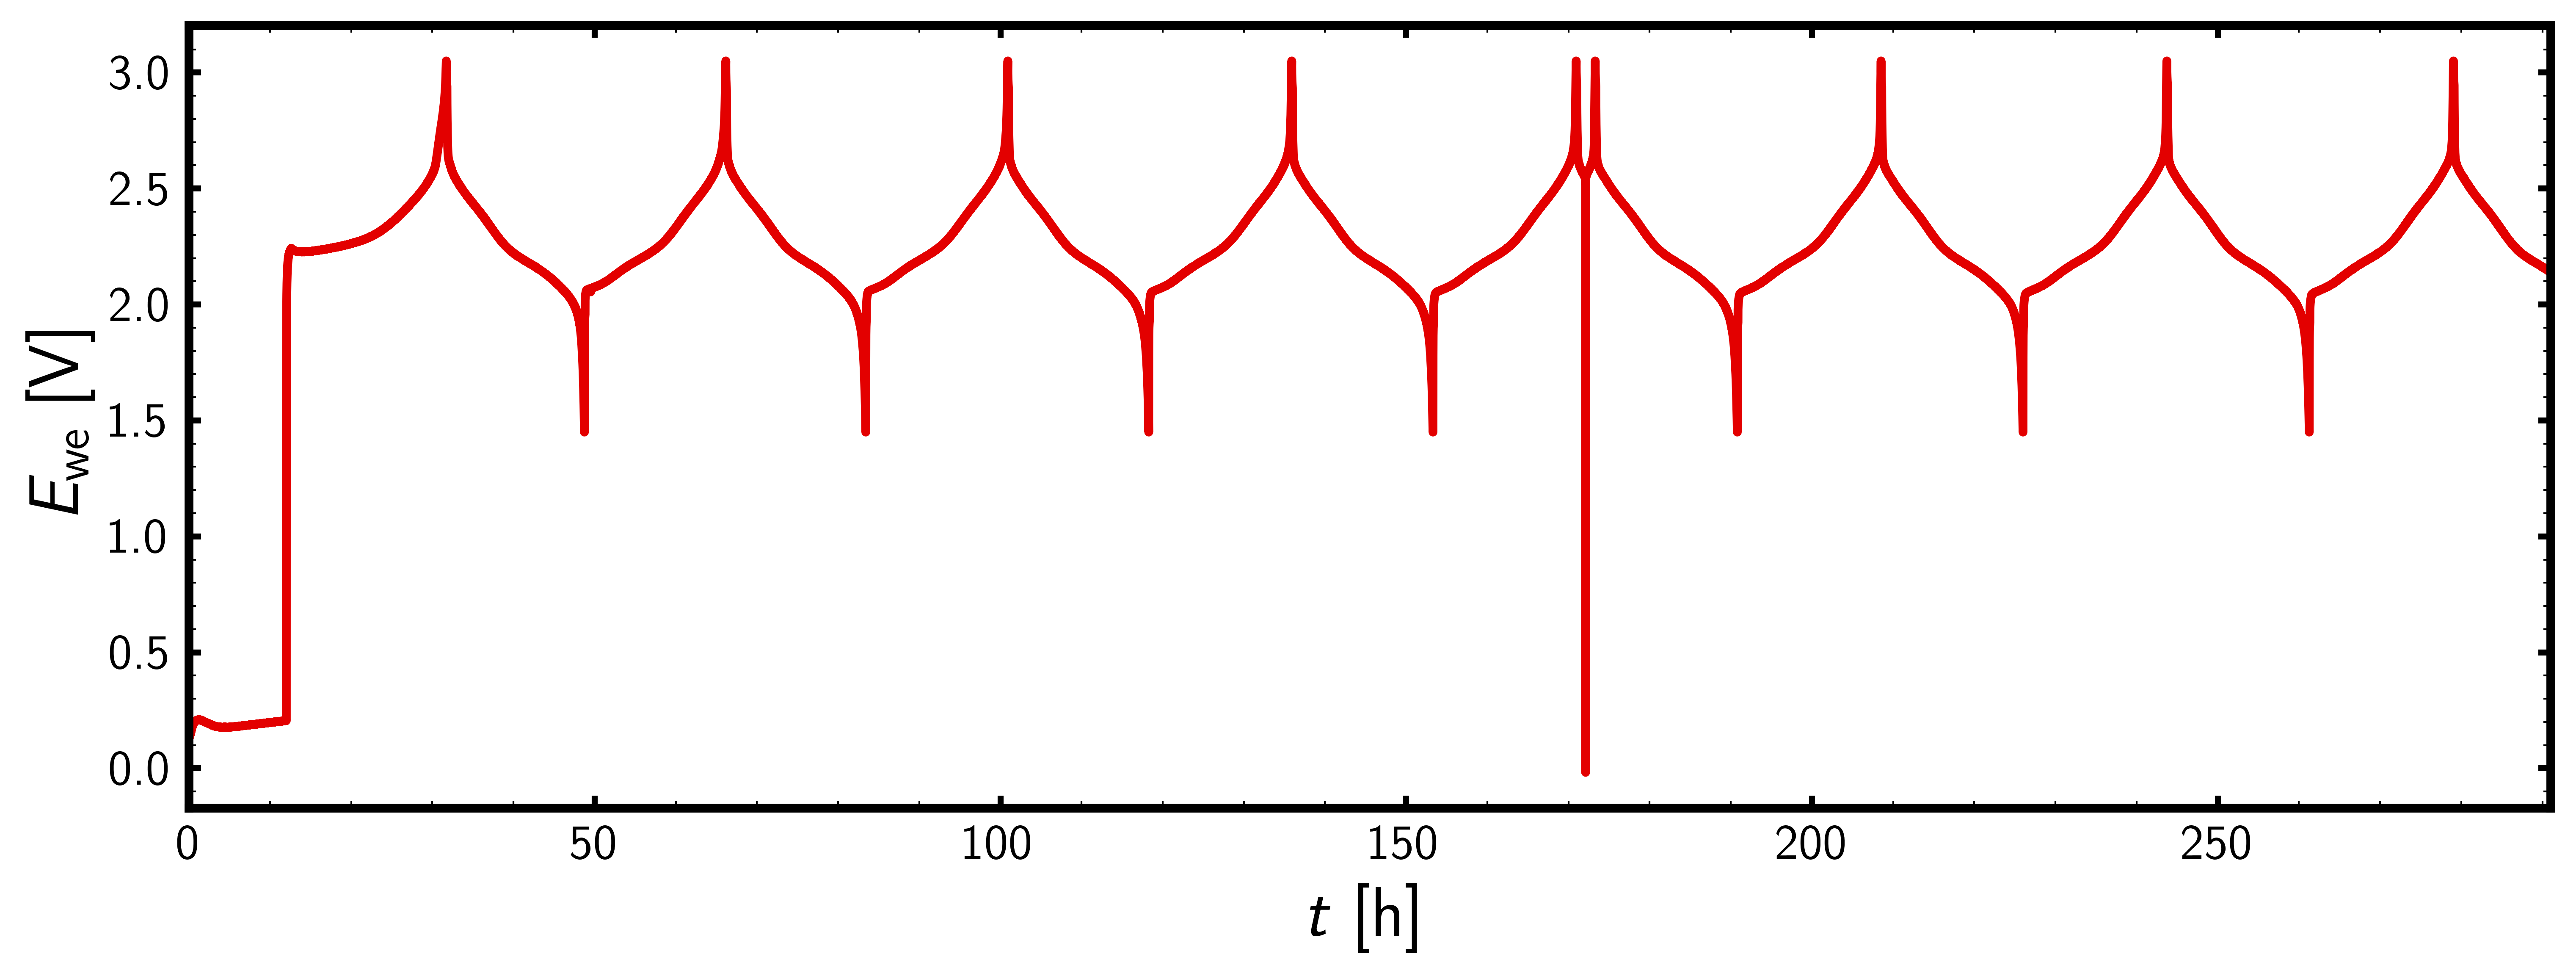

In [36]:
plot_time_voltage(f.stem, d_data, D_PLOT, plot_paths_sample,)

### Plotting: x vs. voltage

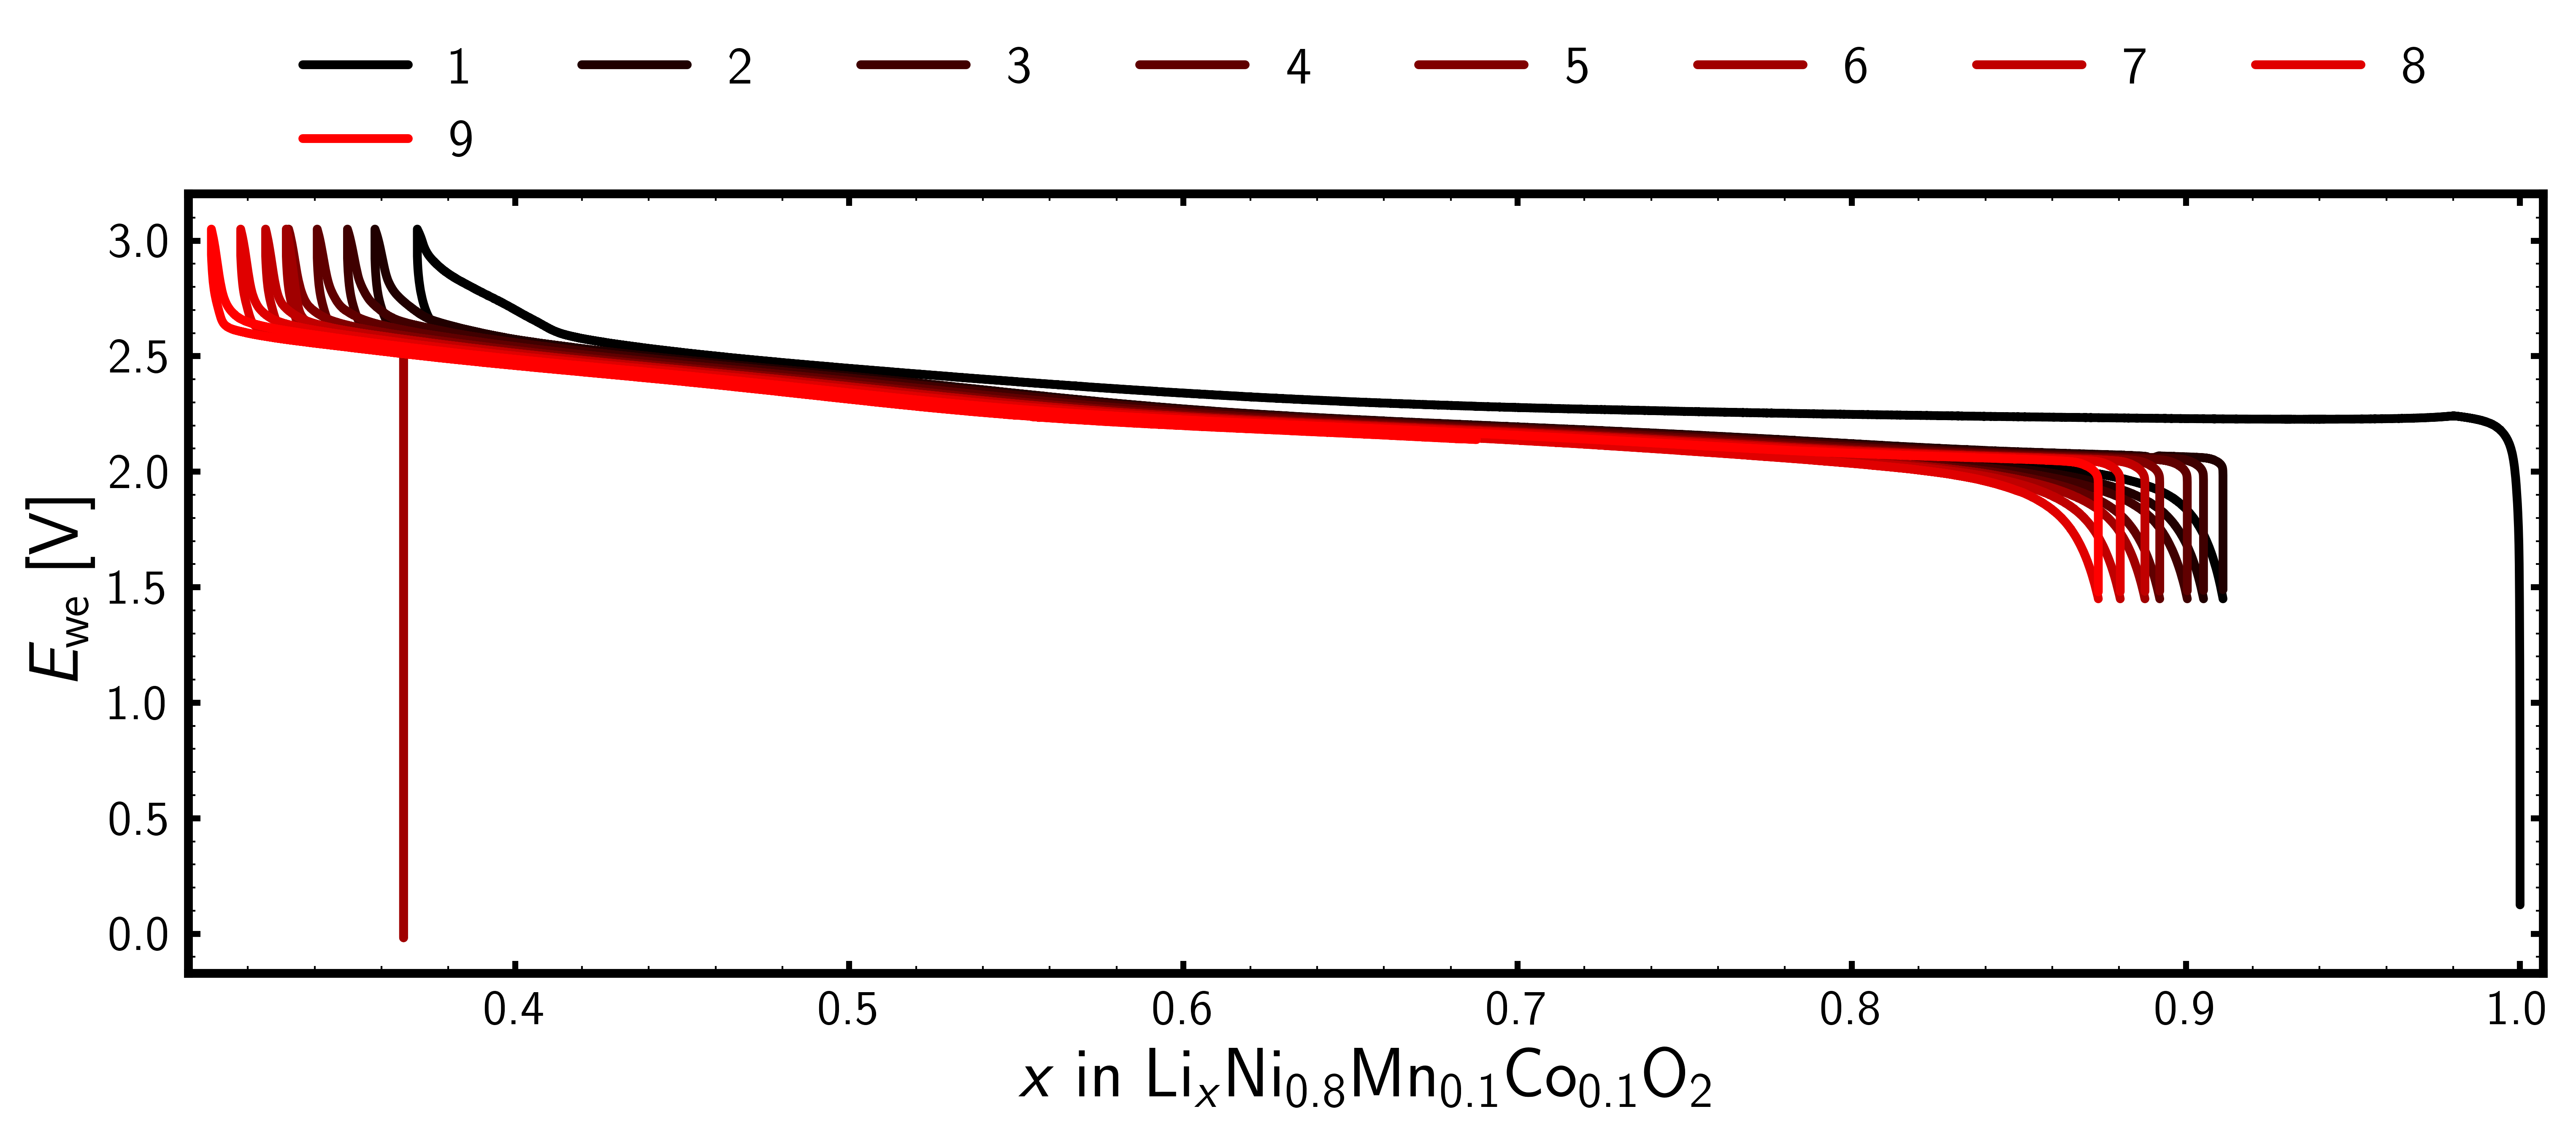

In [37]:
if D_PLOT["cbar_legend"] == "Colorbar":
    plot_x_voltage_cycles_cbar(f.stem, d_half_cycles, D_PLOT, plot_paths_sample,)
elif D_PLOT["cbar_legend"] == "Legend":
    plot_x_voltage_cycles_legend(f.stem, d_half_cycles, D_PLOT, plot_paths_sample,)

### Plotting: capacity vs. voltage

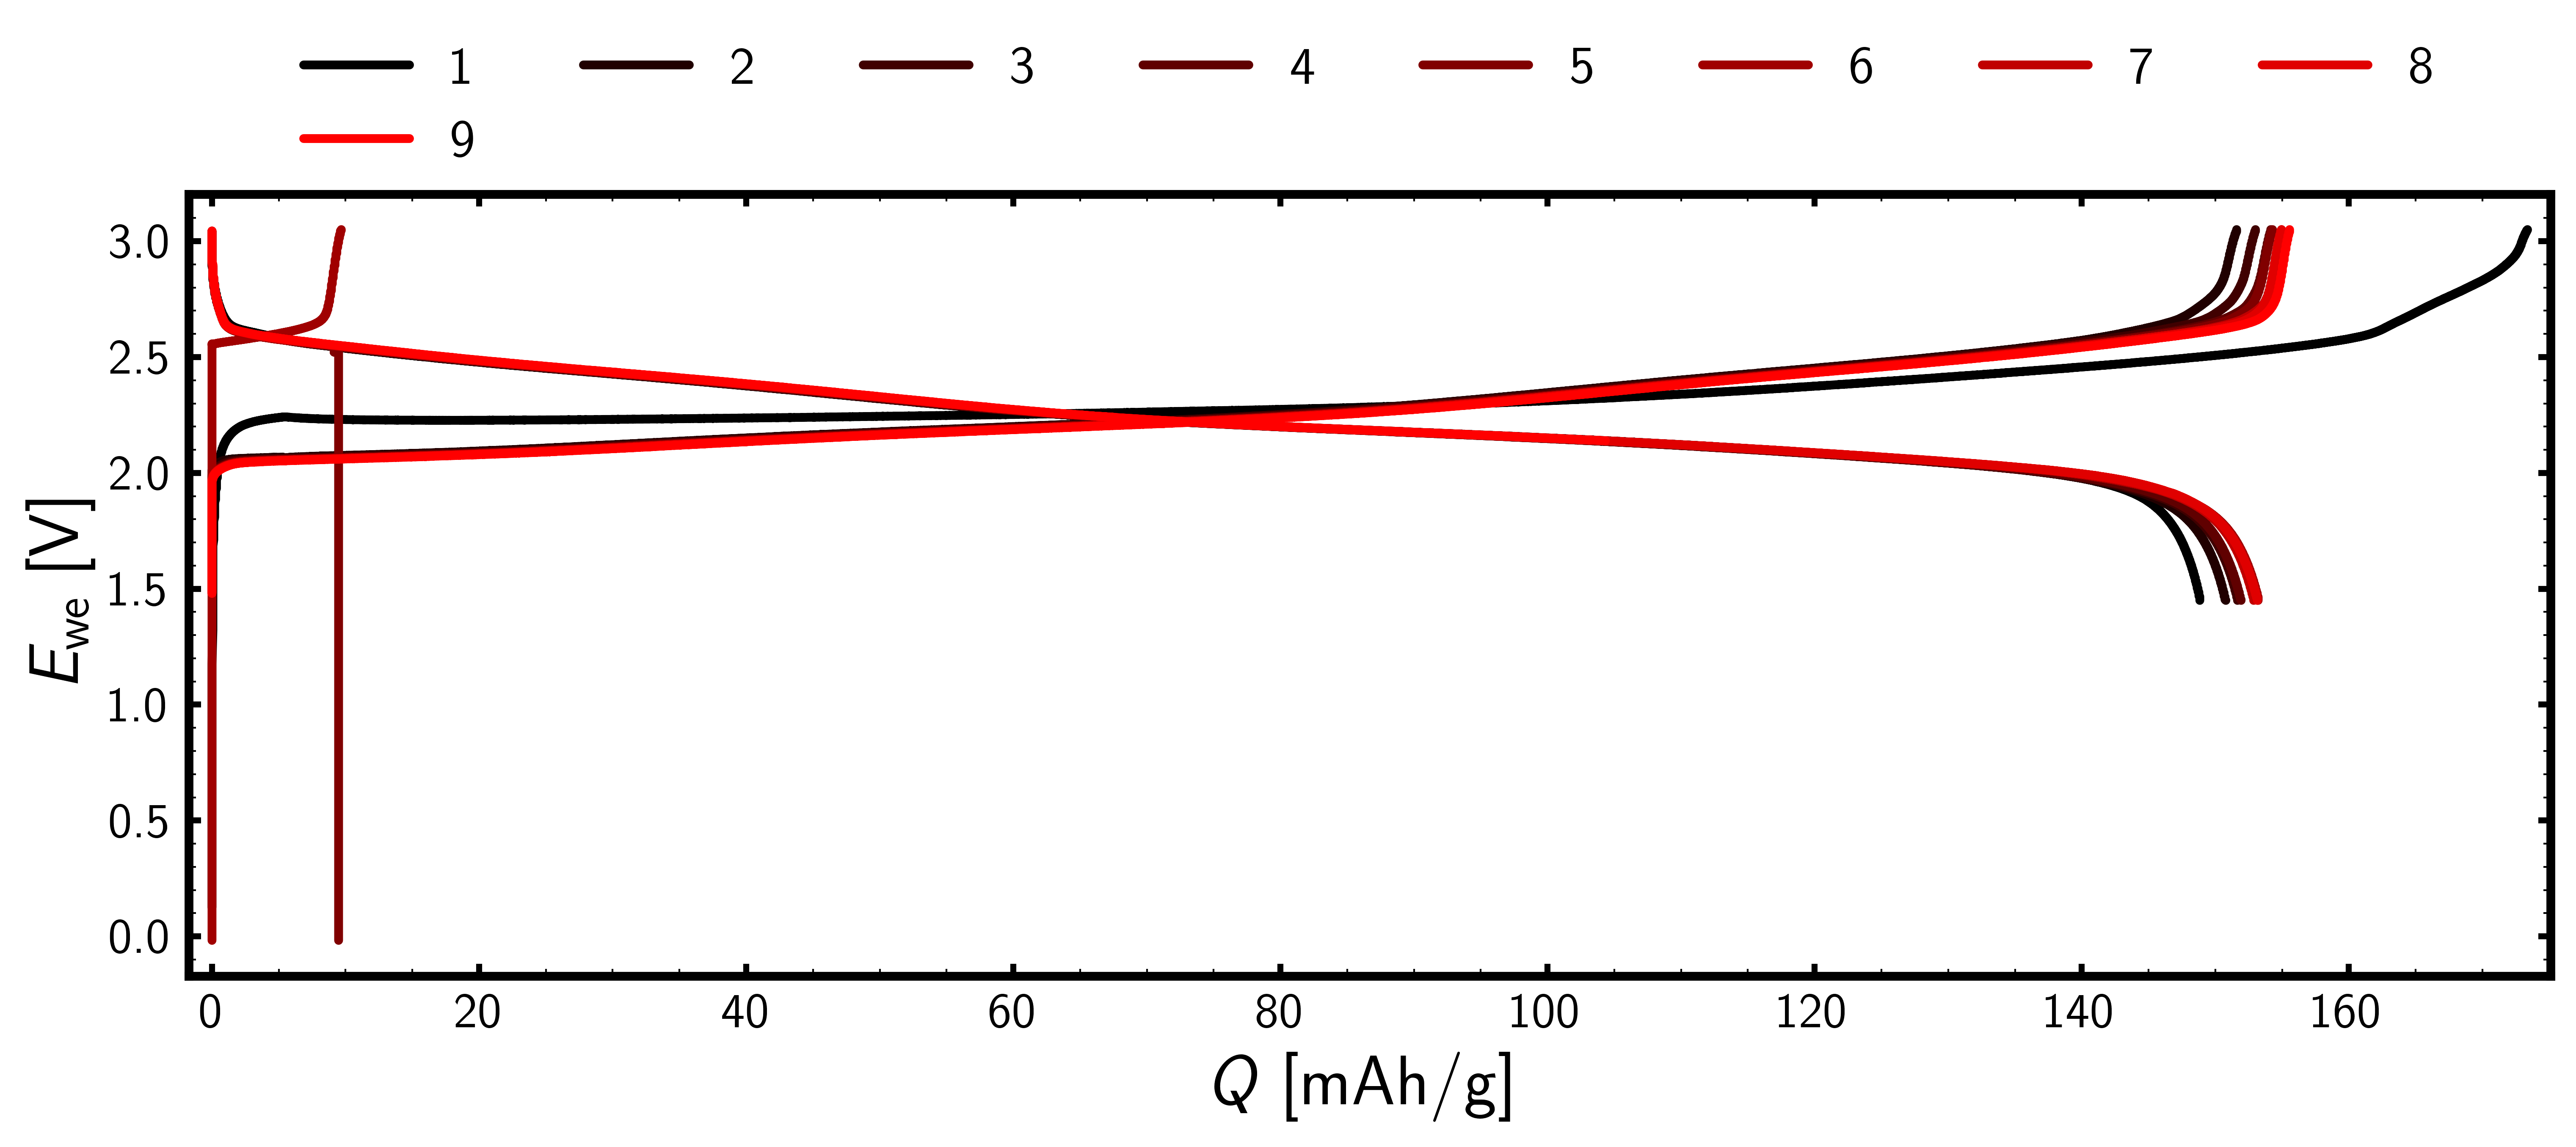

In [38]:
if D_PLOT["cbar_legend"] == "Colorbar":
    plot_capacity_voltage_cbar(f.stem, d_half_cycles, D_PLOT, plot_paths_sample,)
elif D_PLOT["cbar_legend"] == "Legend":
    plot_capacity_voltage_legend(f.stem, d_half_cycles, D_PLOT, plot_paths_sample,)

### Plotting: cycle number vs. capacity

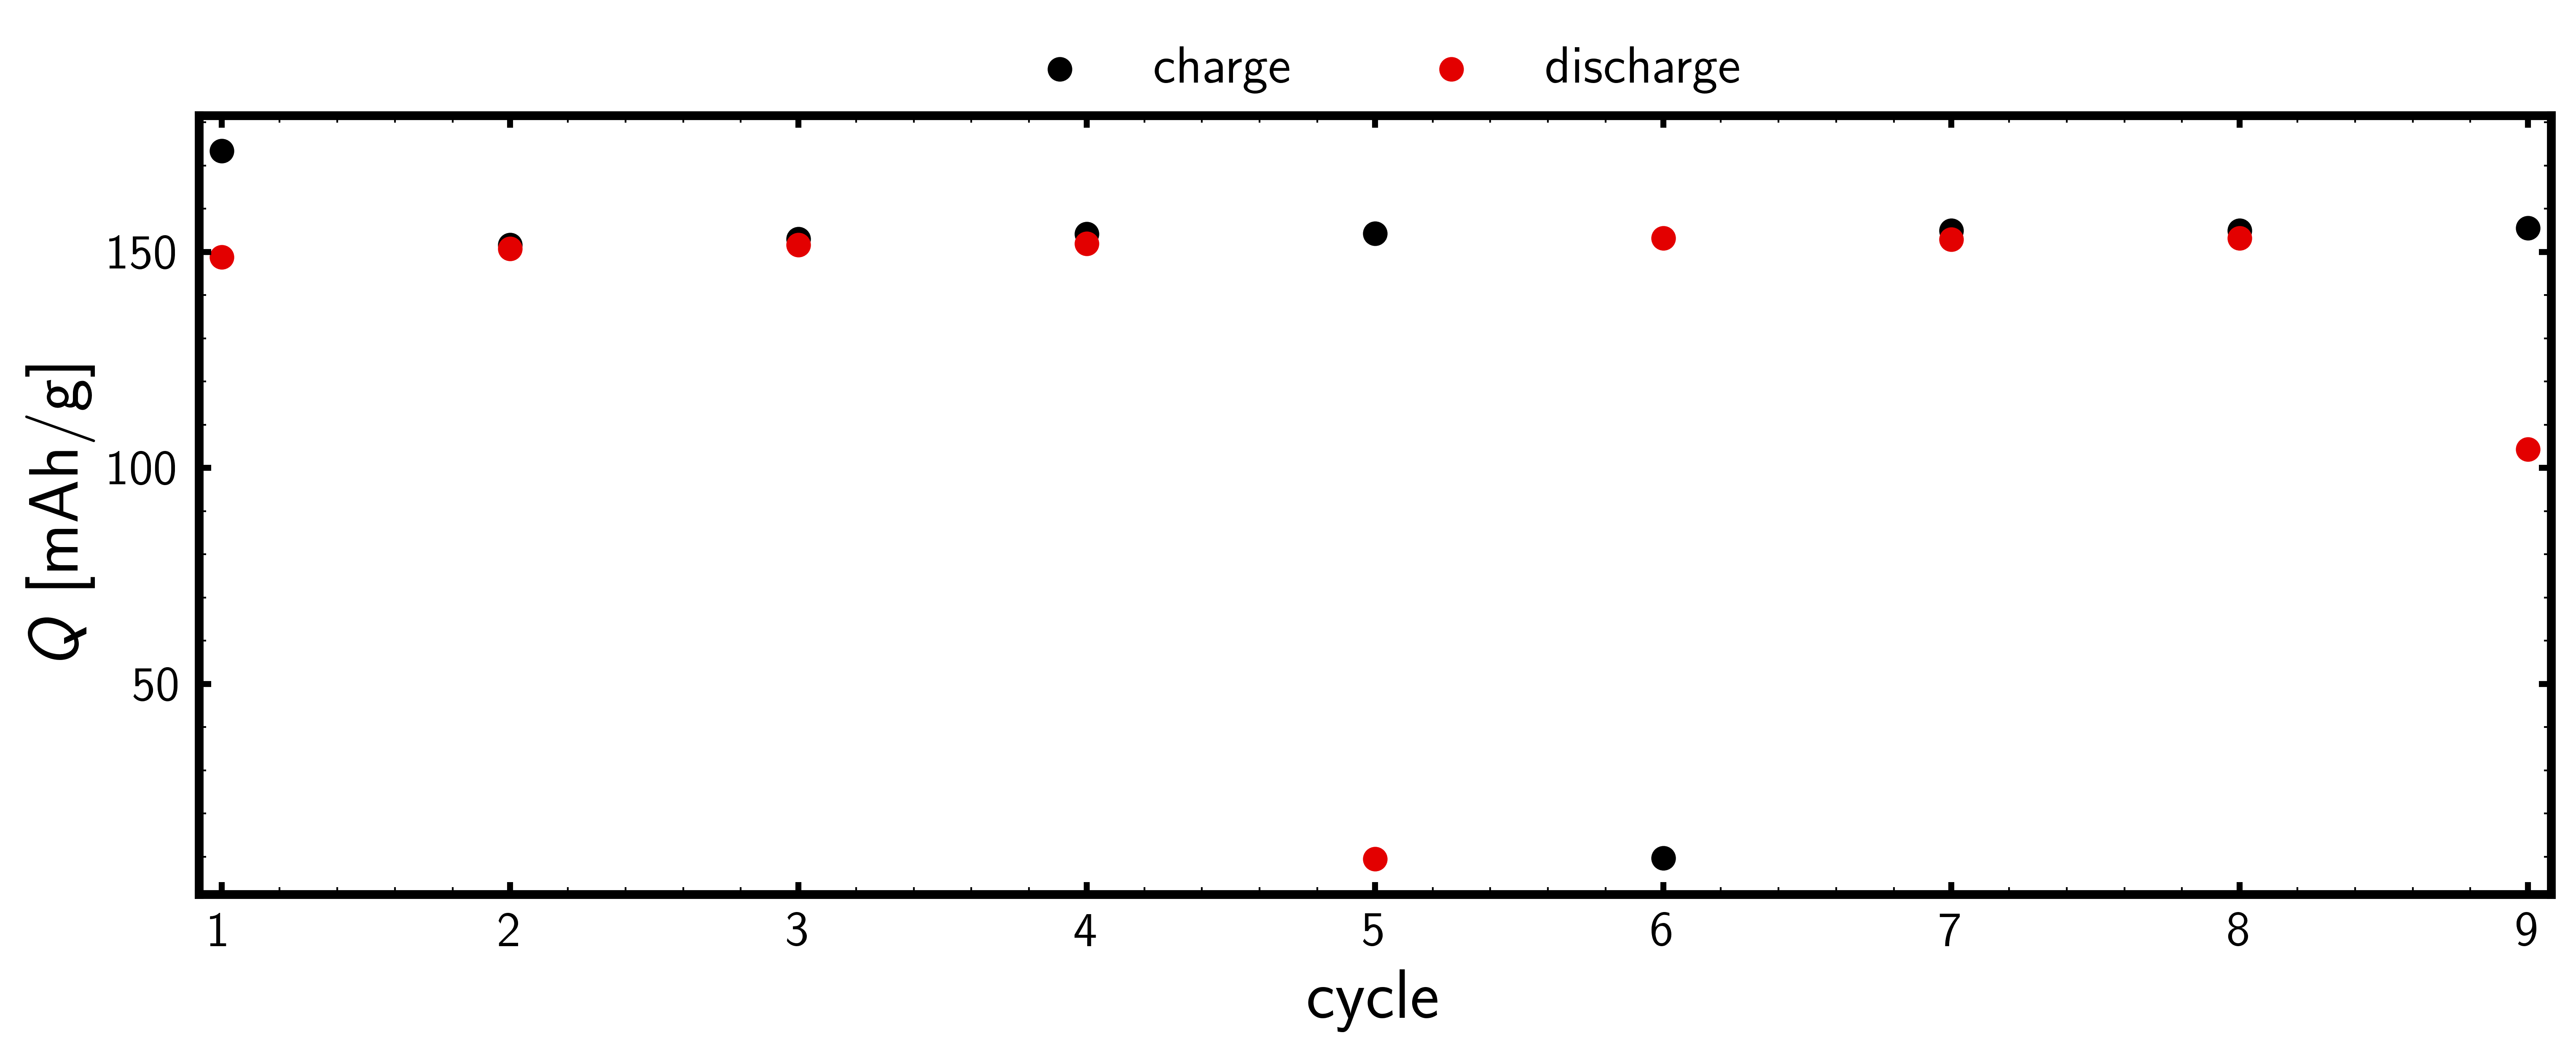

In [39]:
plot_cycle_capacity(f.stem, d_caps, D_PLOT, plot_paths_sample,)

### Plotting: cycle number vs. coulombic efficiency

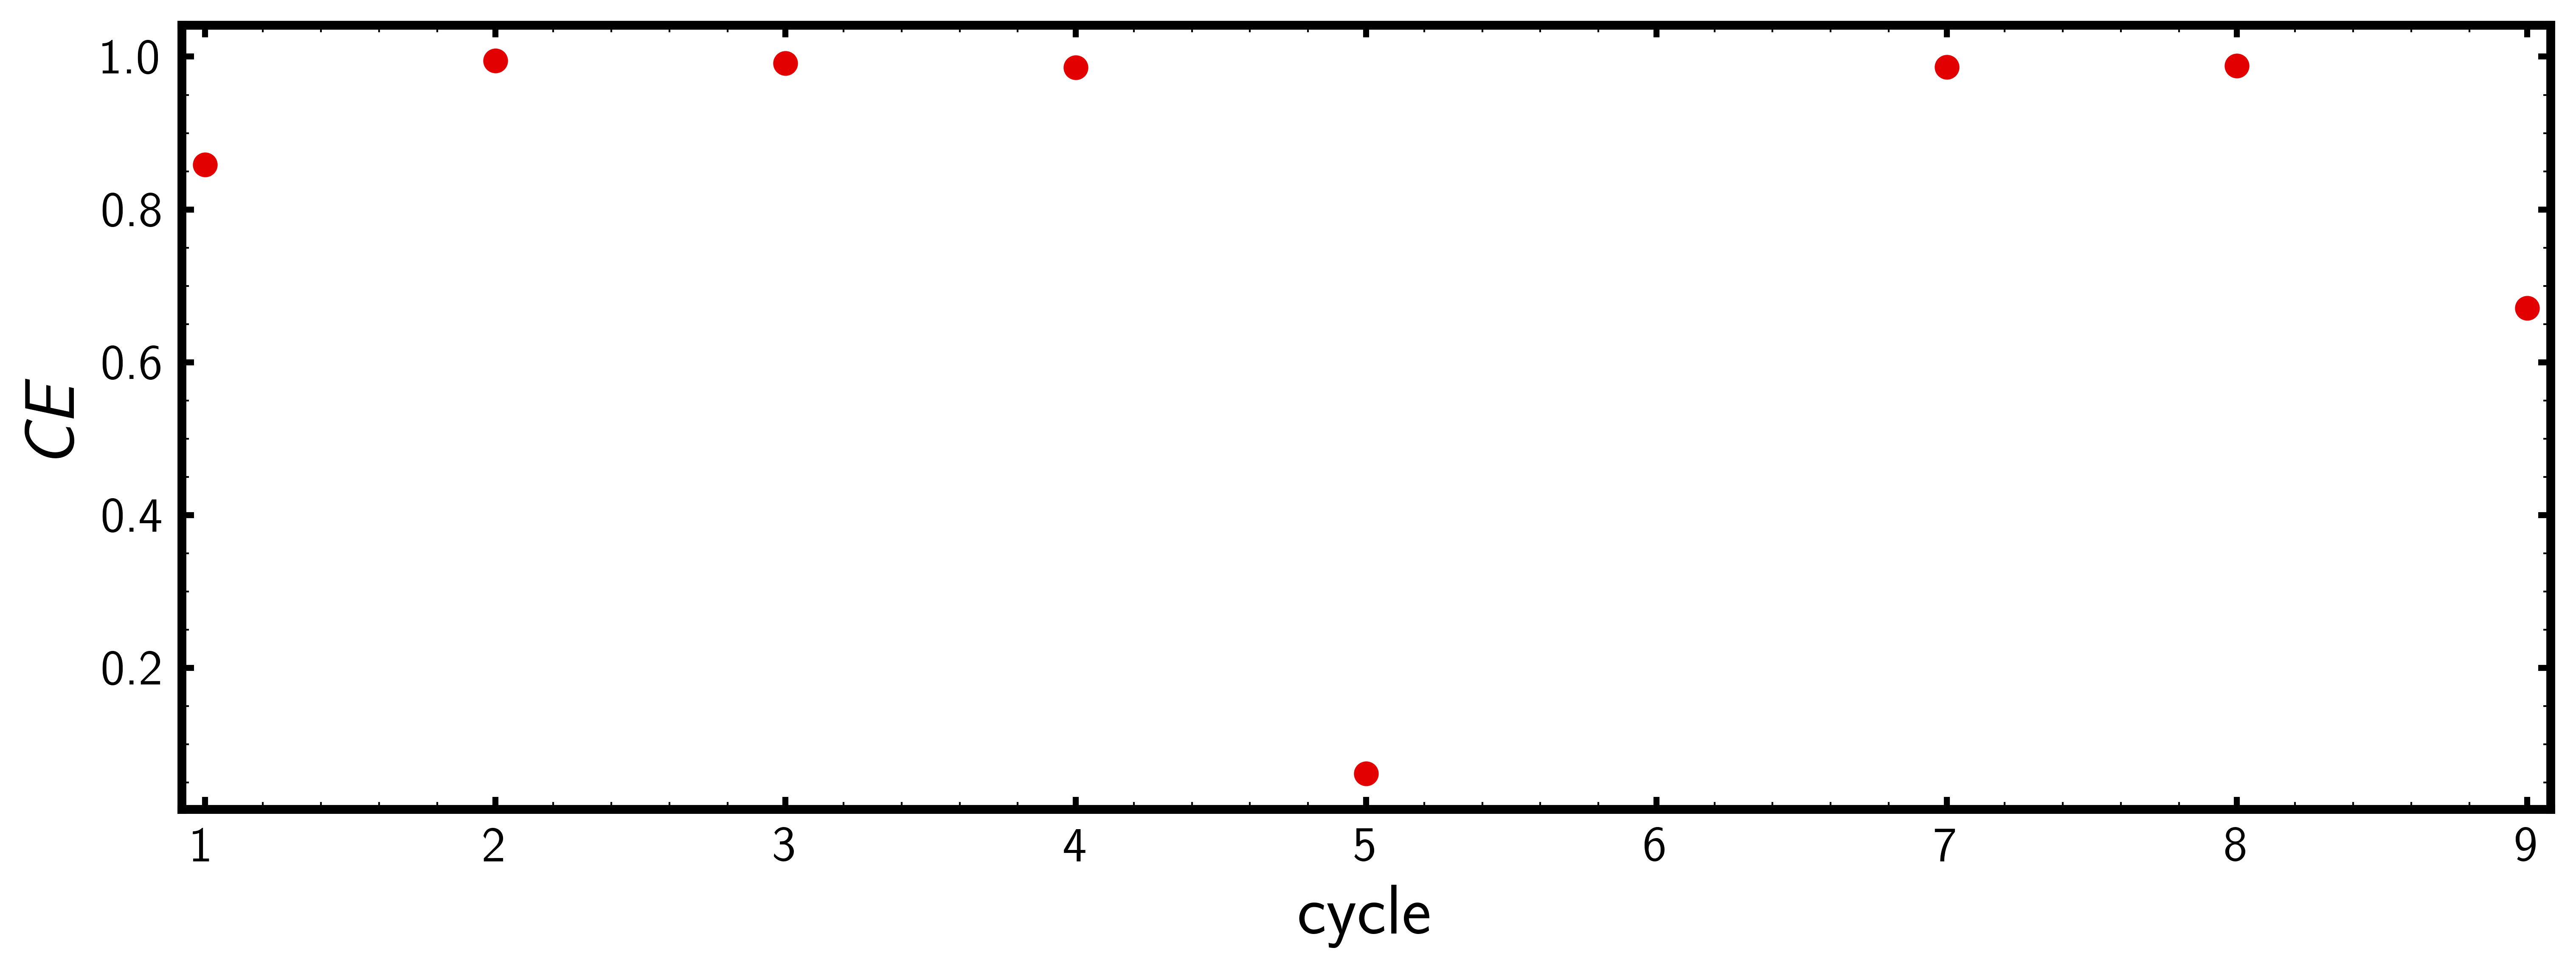

In [40]:
plot_cycle_ce(f.stem, d_caps, D_PLOT, plot_paths_sample)

# End of file